In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import time
import cartopy.crs as ccrs
from shapely.geometry import Point

In [2]:
import matplotlib
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "gabriola"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"


In [3]:
logo = plt.imread('../../Branding/light_logo_1.png')

In [4]:

start_time = time.time()

africa_rivers = gpd.read_file("../../Nature/rivers/data/rivers/namerica/a00000009.gdbtable")
print("--- %s seconds ---" % (time.time() - start_time))

print(africa_rivers)

--- 50.23800444602966 seconds ---
        HYRIV_ID  NEXT_DOWN  MAIN_RIV  LENGTH_KM  DIST_DN_KM  DIST_UP_KM  \
0       70000001          0  70000001       1.72         0.0         5.6   
1       70000002          0  70000002       3.38         0.0         8.3   
2       70000003          0  70000003       1.94         0.0         7.8   
3       70000004          0  70000004       1.12         0.0         8.5   
4       70000005          0  70000005       5.95         0.0        10.1   
...          ...        ...       ...        ...         ...         ...   
986458  70986459          0  70986459      11.29         0.0        13.3   
986459  70986460          0  70986460       1.81         0.0         4.5   
986460  70986461          0  70986461       5.85         0.0        10.3   
986461  70986462          0  70986462       0.69         0.0         2.4   
986462  70986463          0  70986463       0.98         0.0         1.8   

        CATCH_SKM  UPLAND_SKM  ENDORHEIC  DIS_AV_CMS 

In [5]:
lakes = gpd.read_file("../../PythonMapsData/NaturalEarth/10m_physical/ne_10m_lakes.shp")
lakes = lakes.loc[lakes['featurecla'] == 'Lake']
lakes = lakes.dropna(subset=['name'])

country_shapefiles = gpd.read_file("../../PythonMapsData/NaturalEarth/10m_cultural/ne_10m_admin_0_countries.shp")
africa = country_shapefiles.loc[country_shapefiles['CONTINENT'] == 'North America']
africa_lakes = gpd.sjoin(lakes, africa, op='intersects')
africa_lakes = lakes.loc[lakes.index.isin(africa_lakes.index.tolist())]
excluded_rivers = gpd.sjoin(africa_rivers, africa_lakes, op='within')
africa_rivers = africa_rivers.loc[~africa_rivers.index.isin(excluded_rivers.index.tolist())]

C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
#africa_rivers_tmp = africa_rivers.loc[africa_rivers['ORD_FLOW'] < 7]


In [7]:
basins = gpd.read_file("../../Nature/rivers/data/basins/namerica/hydrobasins_northam.shp")
print(basins)

       SUB_BAS  TO_BAS  MAJ_BAS       SUB_NAME  \
0         1001    1005     1001  Upper Roanoke   
1         1002    1004     1001       Banister   
2         1003    1004     1001      Upper Dan   
3         1004    1005     1001      Lower Dan   
4         1005    -999     1001  Lower Roanoke   
...        ...     ...      ...            ...   
10548    50005    -999     4050      Greenland   
10549    50005    -999     4050      Greenland   
10550    50005    -999     4050      Greenland   
10551    50005    -999     4050      Greenland   
10552    50005    -999     4050      Greenland   

                                   MAJ_NAME  SUB_AREA  MAJ_AREA  LEGEND  \
0      Gulf of Mexico, North Atlantic Coast      8689    701385       1   
1      Gulf of Mexico, North Atlantic Coast      1540    701385       1   
2      Gulf of Mexico, North Atlantic Coast      4403    701385       1   
3      Gulf of Mexico, North Atlantic Coast      4204    701385       1   
4      Gulf of Mexico, N

In [8]:
location = Point(-107.23622532421432, 39.41894977595344)
location_df = gpd.GeoDataFrame(pd.DataFrame({"test": ["test"]}), crs="EPSG:4326", geometry = [location])
basin = gpd.sjoin(basins, location_df, predicate="intersects")
print(basin)

      SUB_BAS  TO_BAS  MAJ_BAS      SUB_NAME                 MAJ_NAME  \
1226     7029    7030     1007  Roaring Fork  North America, Colorado   

      SUB_AREA  MAJ_AREA  LEGEND  \
1226      3757    650155       7   

                                               geometry  index_right  test  
1226  POLYGON ((-106.98750 39.50833, -106.97917 39.5...            0  test  


<AxesSubplot:>

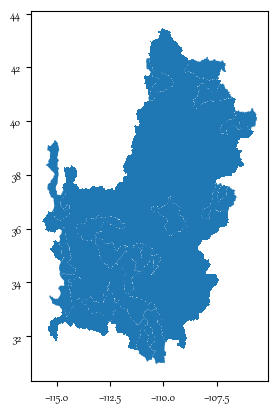

In [9]:
basins = basins.loc[basins['MAJ_NAME'] == 'North America, Colorado']
basins.plot()

In [ ]:
rivers_basins = gpd.sjoin(africa_rivers, basins, op='within')
print(rivers_basins)

C:\Users\symmy\anaconda3\envs\pythonmaps\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [ ]:
from shapely.ops import unary_union

x = unary_union(basins.geometry.tolist())
y = x.boundary
namerica = gpd.GeoDataFrame(pd.DataFrame({'name': ['North America']}), crs="EPSG:4326", geometry=[y])

In [ ]:
import numpy as np

def scale_lw(df: gpd.GeoDataFrame, column_name: str, min_value: float = 0.005, max_value: float = 0.6):
    leftSpan = np.amax(df[column_name]) - np.amin(df[column_name])
    rightSpan = max_value - min_value
    valueScaled = (df[column_name] - np.amin(df[column_name])) / leftSpan
    df[f'LW_{column_name}'] = min_value + (valueScaled * rightSpan)
    return df

rivers_basins = scale_lw(rivers_basins, 'DIST_UP_KM', min_value=0.06, max_value=0.6)

In [ ]:
print(rivers_basins)

In [ ]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(7, 3.5)

rivers_basins.plot(ax=ax, edgecolor='face', color='darkblue', lw=rivers_basins['LW_DIST_UP_KM'])
namerica.plot(ax=ax, color="black", lw=0.1)
location_df.plot(ax=ax, color="black", marker="*")
ax.axis('off')
#ax.set_xlim(-170, -50)
plt.savefig("outputs/namerica_website.jpeg", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)


rivers_basins.plot(ax=ax, edgecolor='face', color='blue', lw=rivers_basins['LW_DEPTH'])
africa_lakes.plot(ax=ax, color='#FCF6F5FF')

newax = fig.add_axes([0.83, 0.62, 0.1, 0.1], anchor='NE', zorder=-1)
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "African Rivers \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

ax.axis('off')
plt.tight_layout()
plt.savefig("outputs/raw5.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)


rivers_basins.plot(ax=ax, edgecolor='face', color='blue', lw=rivers_basins['LW_DEPTH'])
africa_lakes.plot(ax=ax, color='#FCF6F5FF')

newax = fig.add_axes([0.83, 0.62, 0.1, 0.1], anchor='NE', zorder=-1)
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "African Rivers \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

ax.axis('off')
plt.tight_layout()
plt.savefig("outputs/raw5.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(3.5, 7)


rivers_basins.plot(ax=ax, edgecolor='face', color=rivers_basins['colors'], lw=rivers_basins['LW_DEPTH'])
africa_lakes.plot(ax=ax, color='#FCF6F5FF')

newax = fig.add_axes([0.83, 0.62, 0.1, 0.1], anchor='NE', zorder=-1)
newax.imshow(logo)
newax.axis('off')
txt = ax.text(0.02, 0.03, "African Rivers \n@PythonMaps",
              size=6,
              color='grey',
              transform = ax.transAxes,
              fontfamily='fantasy')

ax.axis('off')
plt.tight_layout()
plt.savefig("outputs/raw6.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
africa_rivers = gpd.read_file("../../Nature/rivers/data/rivers/africa/a00000009.gdbtable")

print(africa_rivers)

In [ ]:
tmp_df = africa_rivers.loc[africa_rivers['ORD_FLOW'] < 8]

In [ ]:
leftSpan = np.amax(tmp_df['DIST_UP_KM']) - np.amin(tmp_df['DIST_UP_KM'])
rightSpan = 0.7 - 0.01
valueScaled = (tmp_df['DIST_UP_KM'] - np.amin(tmp_df['DIST_UP_KM'])) / leftSpan
tmp_df['lw'] = 0.01 + (valueScaled * rightSpan)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(5, 7)

tmp_df.plot(ax=ax, color='blue', lw=tmp_df['lw'])
africa_lakes.plot(ax=ax, color='blue', alpha=1)

ax.axis('off')

plt.savefig("outputs/thumbnail.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(5, 7)

tmp_df.plot(ax=ax, color='blue', lw=tmp_df['lw'])
africa_lakes.plot(ax=ax, color='blue', alpha=1)

ax.axis('off')
ax.set_ylim(-20, 20)
plt.savefig("outputs/thumbnail.png", dpi=600, bbox_inches='tight')
plt.show()